## Building a Simple Speech-Enabled Conversational Agent

This script demonstrates a multi-turn speech-based conversational pipeline using Automatic Speech Recognition (ASR), a Large Language Model (LLM), and Text-to-Speech (TTS) synthesis. It handles three user interactions, maintains conversation history, and saves a summary.

Key Libraries Used:

    speech_recognition: Captures microphone input and performs ASR via Google's API

    transformers: Provides the pipeline API for text generation using GPT-2

    gTTS: Converts text responses to synthetic speech

    playsound: Plays generated audio responses

    os: Handles temporary audio file cleanup

Code Logic and Flow

The pipeline runs three conversational turns:

    Capture user speech via microphone and transcribe to text

    Generate contextual responses using conversation history

    Convert responses to speech and play them aloud
    After three turns, a summary of the conversation is saved to a text file.
    
Visual FlowChart:

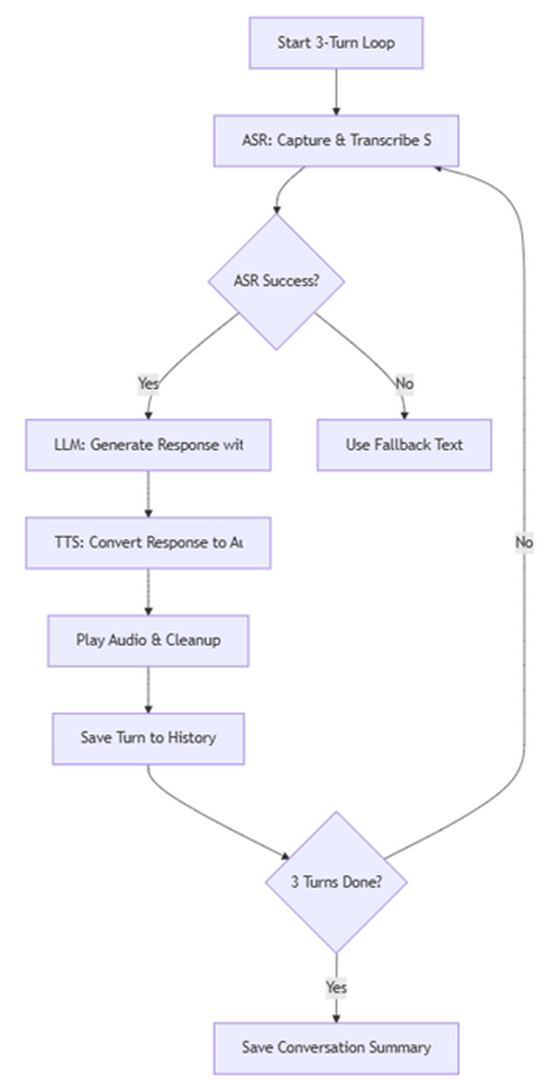

Step-by-Step Code Breakdown

1. ASR Processing

    Microphone audio capture with ambient noise adjustment

    Speech transcription using Google's web-based ASR service

    Error handling for failed recognitions or service errors

2. LLM Processing

    Constructs a prompt with entire conversation history

    Uses GPT-2 to generate context-aware responses

    Extracts the first clean response line from model output

3. TTS Processing

    Converts text responses to spoken English using Google's TTS

    Saves audio as MP3, plays it immediately, then deletes the file

4. Conversation Management

    Maintains a list of user/response pairs across turns

    After three iterations, prints and saves the full history to a text file

Connecting to Lecture Concepts

This implementation demonstrates core challenges in spoken dialogue systems:

    Latency: Real-time constraints in ASR/TTS APIs impact user experience

    Error Propagation: ASR mistakes directly affect LLM's understanding (no error correction)

    Context Handling: Shows how conversation history improves response relevance

    Component Integration: Highlights glue code requirements between ML components

    Demo Limitations: Uses non-real-time APIs (Google services) and a basic LLM without fine-tuning, aligning with discussions about production system tradeoffs.   

    


In [4]:
import speech_recognition as sr
import openai
from gtts import gTTS
import os
import torch
import pygame
from transformers import pipeline as hf_pipeline
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
os.environ["PYGAME_HIDE_SUPPORT_PROMPT"] = "1"
output_file = "response.mp3"

# Initialize components
recognizer = sr.Recognizer()
# ROCm exposes HIP through PyTouch's CUDA API 
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available
llm = hf_pipeline("text-generation", model="gpt2", device=device)  # Simple LLM for demo
client = openai.OpenAI(api_key=openai_api_key)

def asr_process():
    """Step 1: Automatic Speech Recognition (ASR)"""
    with sr.Microphone(device_index=9) as source:
        print("Listening for your query...")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)
    try:
        text = recognizer.recognize_google(audio)
        print(f"Transcribed: {text}")
        return text
    except sr.UnknownValueError:
        print("Could not understand audio.")
        return None
    except sr.RequestError:
        print("ASR service error.")
        return None

def llm_process(text, conversation_history):
    """Step 2: Large Language Model (LLM) with conversation history using GPT-4o-mini"""
    if text:
        # Build prompt with conversation history
        prompt = "Conversation history:\n"
        for i, turn in enumerate(conversation_history):
            prompt += f"Turn {i+1} - User: {turn['user']}\nResponse: {turn['response']}\n"
        prompt += f"Current user query: {text}\nRespond appropriately."

        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=100,
                n=1,
                temperature=0.7,
            )
            response_text = response.choices[0].message.content.strip()
            print(f"LLM Response: {response_text}")
            return response_text
        except Exception as e:
            print(f"LLM API error: {e}")
            return "Sorry, I couldn't process your request."
    return "Sorry, I didn't understand."

def tts_process(text):
    """Step 3: Text-to-Speech (TTS)"""
    tts = gTTS(text=text, lang="en")
    tts.save(output_file)
    print("Playing response...")
    pygame.mixer.init()
    pygame.mixer.music.load(output_file)
    pygame.mixer.music.play()

    while pygame.mixer.music.get_busy():
        continue
    os.remove(output_file)  # Clean up

def save_conversation_summary(conversation_history):
    """Save conversation summary to a text file"""
    with open("conversation_summary.txt", "w") as f:
        f.write("Conversation Summary:\n")
        for i, turn in enumerate(conversation_history):
            f.write(f"Turn {i+1}:\n")
            f.write(f"User: {turn['user']}\n")
            f.write(f"Response: {turn['response']}\n\n")
    print("Conversation summary saved to conversation_summary.txt")

def run_pipeline():
    """Run the full ASR + LLM + TTS pipeline for three turns"""
    conversation_history = []
    num_turns = 3

    for turn in range(num_turns):
        print(f"\n--- Turn {turn+1} ---")
        # Step 1: ASR
        transcribed_text = asr_process()
        if transcribed_text is None:
            transcribed_text = "Could not transcribe audio."

        # Step 2: LLM
        response_text = llm_process(transcribed_text, conversation_history)

        # Step 3: TTS
        tts_process(response_text)

        # Update conversation history
        conversation_history.append({
            "user": transcribed_text,
            "response": response_text
        })

    # Print and save conversation summary
    print("\n--- Conversation Summary ---")
    for i, turn in enumerate(conversation_history):
        print(f"Turn {i+1}:")
        print(f"User: {turn['user']}")
        print(f"Response: {turn['response']}\n")

    save_conversation_summary(conversation_history)

if __name__ == "__main__":
    run_pipeline()

Loading weights: 100%|██████████| 148/148 [00:00<00:00, 2467.35it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



--- Turn 1 ---


ALSA lib pcm_dsnoop.c:572:(snd_pcm_dsnoop_open) [error.pcm] unable to open slave
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) [error.pcm] unable to open slave
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadW

Listening for your query...
Transcribed: can you hear me
LLM Response: Yes, I can "hear" you in the sense that I can read your messages. How can I assist you today?
Playing response...

--- Turn 2 ---


ALSA lib pcm_dsnoop.c:572:(snd_pcm_dsnoop_open) [error.pcm] unable to open slave
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) [error.pcm] unable to open slave
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadW

KeyboardInterrupt: 